In [38]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

import matplotlib.pyplot as plt

In [37]:
#model = models.mobilenet_v2(pretrained=True).eval()


In [39]:
# loading images from imagenet_samples folder
Brambling_img = Image.open('imagenet_samples/Brambling.jpg')
goldfish_img = Image.open('imagenet_samples/goldfish.jpeg')
hen_img = Image.open('imagenet_samples/hen.jpg')
tench_img = Image.open('imagenet_samples/tench.png')
White_shark_img = Image.open('imagenet_samples/White_shark.jpg')

In [40]:
images = [Brambling_img, goldfish_img, hen_img,tench_img,White_shark_img]
images = [image.convert('RGB') for image in images] #change images to RGB 


In [41]:
import torchvision.transforms as transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

processed_images = [preprocess(image) for image in images]


In [1]:
#from torchcam.utils import overlay_mask
#from torchcam.cams import GradCAM


In [42]:
import torch
import torchvision.models as models
import torch.nn.functional as F

class MobileNetV2WithFeatures(models.MobileNetV2):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        
        x = self.features(x)

        feature_maps = x

        
        x = F.adaptive_avg_pool2d(x, (1, 1))  
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, feature_maps


In [46]:
model = MobileNetV2WithFeatures()
model.eval()  


MobileNetV2WithFeatures(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNor

In [47]:
for input_tensor in processed_images:
    input_tensor = input_tensor.unsqueeze(0)  

    
    output, feature_maps = model(input_tensor)


    fc_layer = model.classifier[1]
    fc_weights = fc_layer.weight.data

    
    class_idx = torch.argmax(output)

    
    class_weights = fc_weights[class_idx]

    
    cam = torch.zeros_like(feature_maps[0])
    for i, w in enumerate(class_weights):
        cam += w * feature_maps[0, i, :, :]

    
    cam = F.relu(cam)

    cam = cam - cam.min()
    cam = cam / cam.max()

    


In [48]:
from PIL import Image

image_paths = ['imagenet_samples/Brambling.jpg', 'imagenet_samples/goldfish.jpeg', 'imagenet_samples/hen.jpg', 'imagenet_samples/tench.png', 'imagenet_samples/white_shark.jpg']  
original_images = [Image.open(path) for path in image_paths]


In [35]:
import numpy as np

def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    tensor = tensor.clone().detach().numpy()
    tensor = tensor * std + mean  
    tensor = np.clip(tensor, 0, 1)  
    return tensor.transpose(1, 2, 0)  


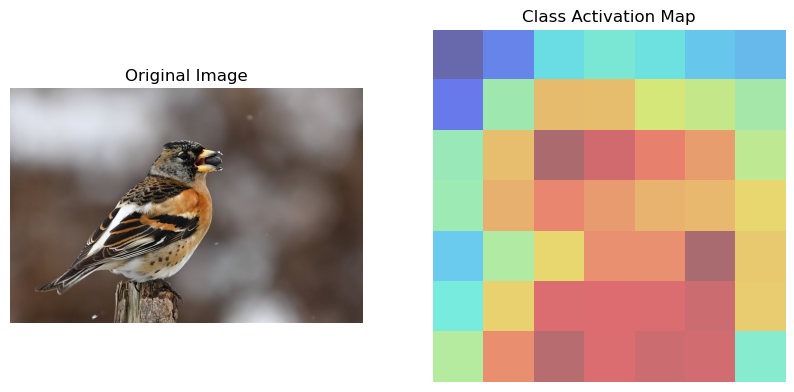

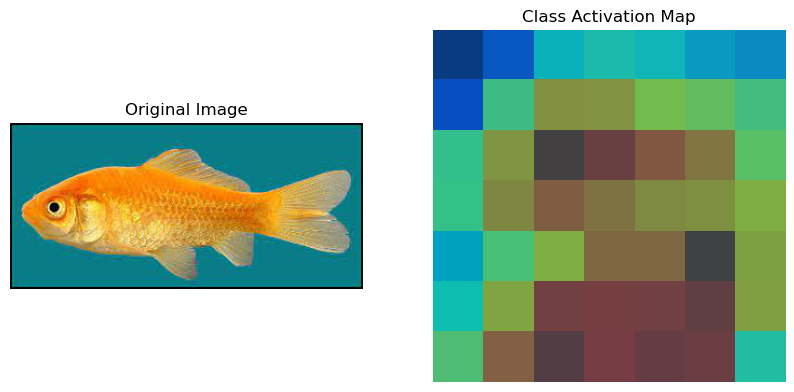

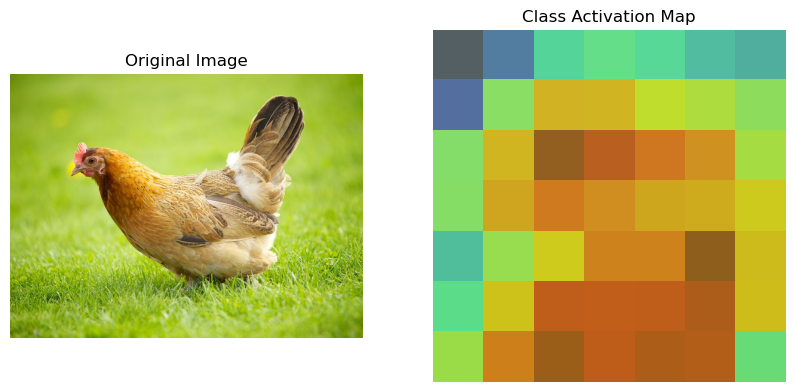

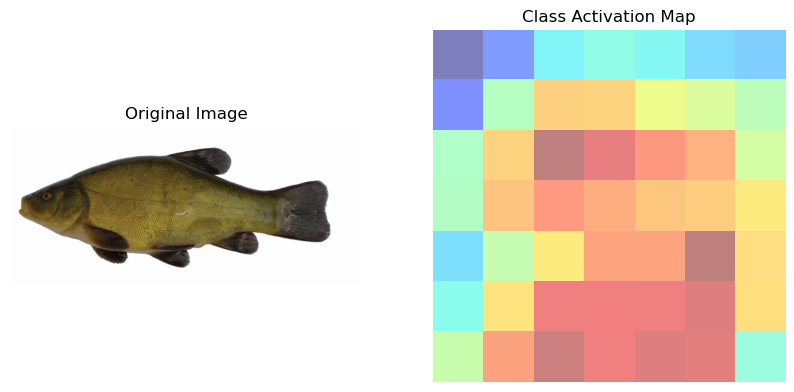

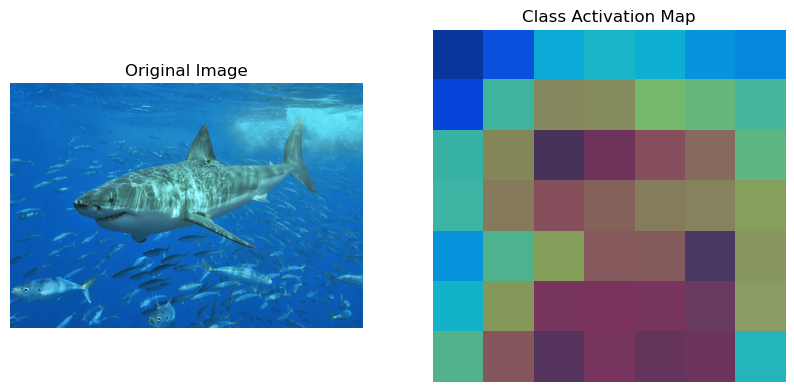

In [36]:
for i, input_tensor in enumerate(processed_images):
   
    plt.figure(figsize=(10, 5))

    
    plt.subplot(1, 2, 1)
    plt.imshow(original_images[i])  
    plt.title("Original Image")
    plt.axis('off')

    
    plt.subplot(1, 2, 2)
    cam_np = cam.cpu().detach().numpy().squeeze()  

    
    if cam_np.ndim > 2:
        cam_np = np.mean(cam_np, axis=0)  

    cam_np = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min())  
    input_img_np = denormalize(input_tensor.squeeze(0))
    if input_img_np.shape[-1] != 3:
        input_img_np = input_img_np.transpose(1, 2, 0)

    plt.imshow(input_img_np)  
    plt.imshow(cam_np, cmap='jet', alpha=0.5)  
    plt.title("Class Activation Map")
    plt.axis('off')

    plt.show()
